## Introduction
### Case Study
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

### Importing Libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

import pickle

### Importing Data

In [2]:
sales = pd.read_csv('Data/train.csv')

In [3]:
sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


### Store Data

In [4]:
stores = pd.read_csv('Data/store.csv')

In [5]:
stores

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
stores.shape

(1115, 10)

In [7]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
# We can see some null values in the store features 

In [9]:
# check for null values
stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [10]:
# remove features with a lot of missing values
stores = stores.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

In [11]:
# replace null values in 'CompetitionDistance' with median distance
stores['CompetitionDistance'] = stores['CompetitionDistance'].fillna(stores['CompetitionDistance'].median())

In [12]:
# check the updated stores DataFrame
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2
0,1,c,a,1270.0,0
1,2,a,a,570.0,1
2,3,a,a,14130.0,1
3,4,c,c,620.0,0
4,5,a,a,29910.0,0


In [13]:
# check all the values of CompetitionDistance
stores['CompetitionDistance'].unique()

array([1.270e+03, 5.700e+02, 1.413e+04, 6.200e+02, 2.991e+04, 3.100e+02,
       2.400e+04, 7.520e+03, 2.030e+03, 3.160e+03, 9.600e+02, 1.070e+03,
       1.300e+03, 4.110e+03, 3.270e+03, 5.000e+01, 1.384e+04, 3.240e+03,
       2.340e+03, 5.500e+02, 1.040e+03, 4.060e+03, 4.590e+03, 4.300e+02,
       2.300e+03, 6.000e+01, 1.200e+03, 2.170e+03, 4.000e+01, 9.800e+03,
       2.910e+03, 1.320e+03, 2.240e+03, 7.660e+03, 5.400e+02, 4.230e+03,
       1.090e+03, 2.600e+02, 1.800e+02, 1.180e+03, 2.900e+02, 4.880e+03,
       9.710e+03, 2.700e+02, 1.060e+03, 1.801e+04, 6.260e+03, 1.057e+04,
       4.500e+02, 3.036e+04, 7.170e+03, 7.200e+02, 6.620e+03, 4.200e+02,
       7.340e+03, 2.840e+03, 5.540e+03, 3.500e+02, 2.050e+03, 3.700e+03,
       2.256e+04, 4.100e+02, 2.500e+02, 1.130e+03, 4.840e+03, 1.750e+04,
       2.200e+03, 1.650e+03, 3.300e+02, 2.244e+04, 1.996e+04, 3.510e+03,
       3.320e+03, 7.910e+03, 2.370e+03, 2.239e+04, 2.710e+03, 1.181e+04,
       1.870e+03, 4.800e+02, 5.600e+02, 1.069e+04, 

In [14]:
# merge sales and stores data
merged_data = sales.merge(stores, how='left', on='Store')
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,0


In [15]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   DayOfWeek            1017209 non-null  int64  
 2   Date                 1017209 non-null  object 
 3   Sales                1017209 non-null  int64  
 4   Customers            1017209 non-null  int64  
 5   Open                 1017209 non-null  int64  
 6   Promo                1017209 non-null  int64  
 7   StateHoliday         1017209 non-null  object 
 8   SchoolHoliday        1017209 non-null  int64  
 9   StoreType            1017209 non-null  object 
 10  Assortment           1017209 non-null  object 
 11  CompetitionDistance  1017209 non-null  float64
 12  Promo2               1017209 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 100.9+ MB


In [16]:
merged_data.shape

(1017209, 13)

In [17]:
# check for null values
merged_data.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

In [18]:
# describe the data
round(merged_data.describe().T, 2)


,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1017209.0,5422.02,7706.92,20.0,710.0,2325.0,6880.0,75860.0
Promo2,1017209.0,0.50,0.50,0.0,0.0,1.0,1.0,1.0


In [19]:
# check for duplicate values
merged_data.duplicated().sum()

np.int64(0)

In [20]:
# no of stores
merged_data['Store'].nunique()

1115

In [21]:
# parse the date column
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [22]:
print(merged_data.Date.min(), '- Start Date')
print(merged_data.Date.max(), '- End Date')

2013-01-01 00:00:00 - Start Date
2015-07-31 00:00:00 - End Date


In [23]:
merged_data.Date.min(), merged_data.Date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [24]:
# let's extract some features from the date column
merged_data['Year'] = merged_data.Date.dt.year
merged_data['Month'] = merged_data.Date.dt.month
merged_data['Day'] = merged_data.Date.dt.day


In [25]:
merged_data.shape

(1017209, 16)

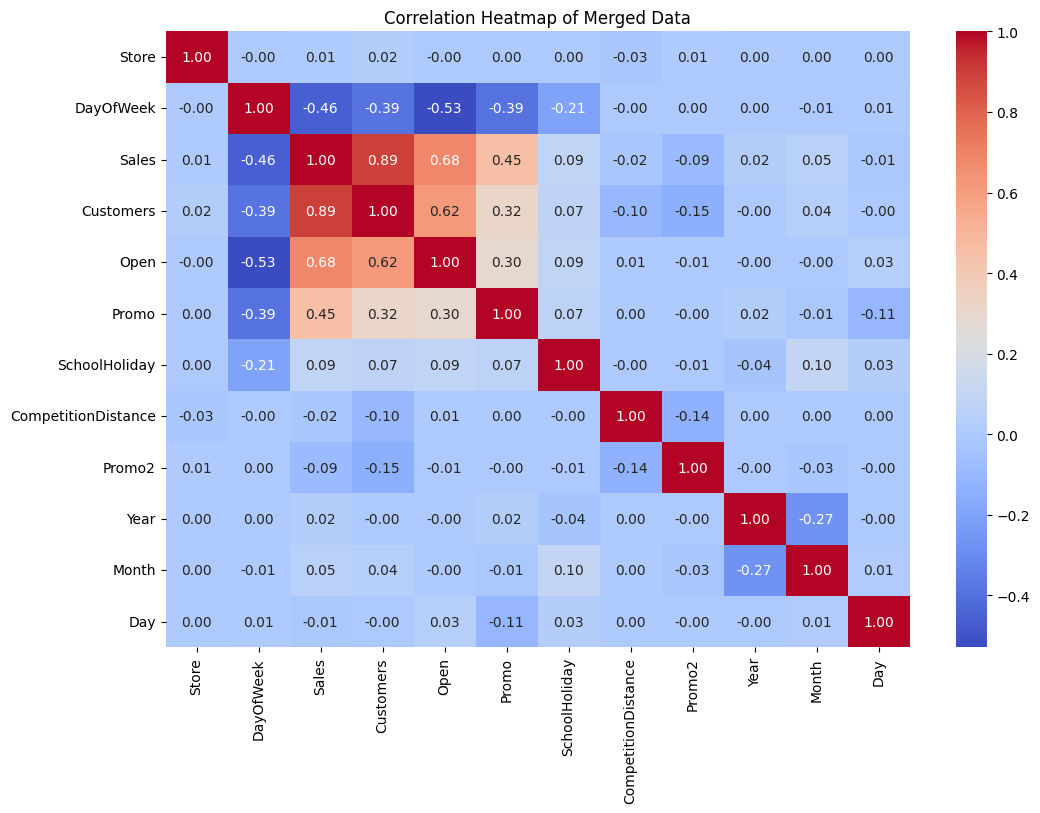

In [26]:
# heatmap of merged data (numeric columns only)
plt.figure(figsize=(12, 8))
numeric_cols = merged_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Merged Data')
plt.show()

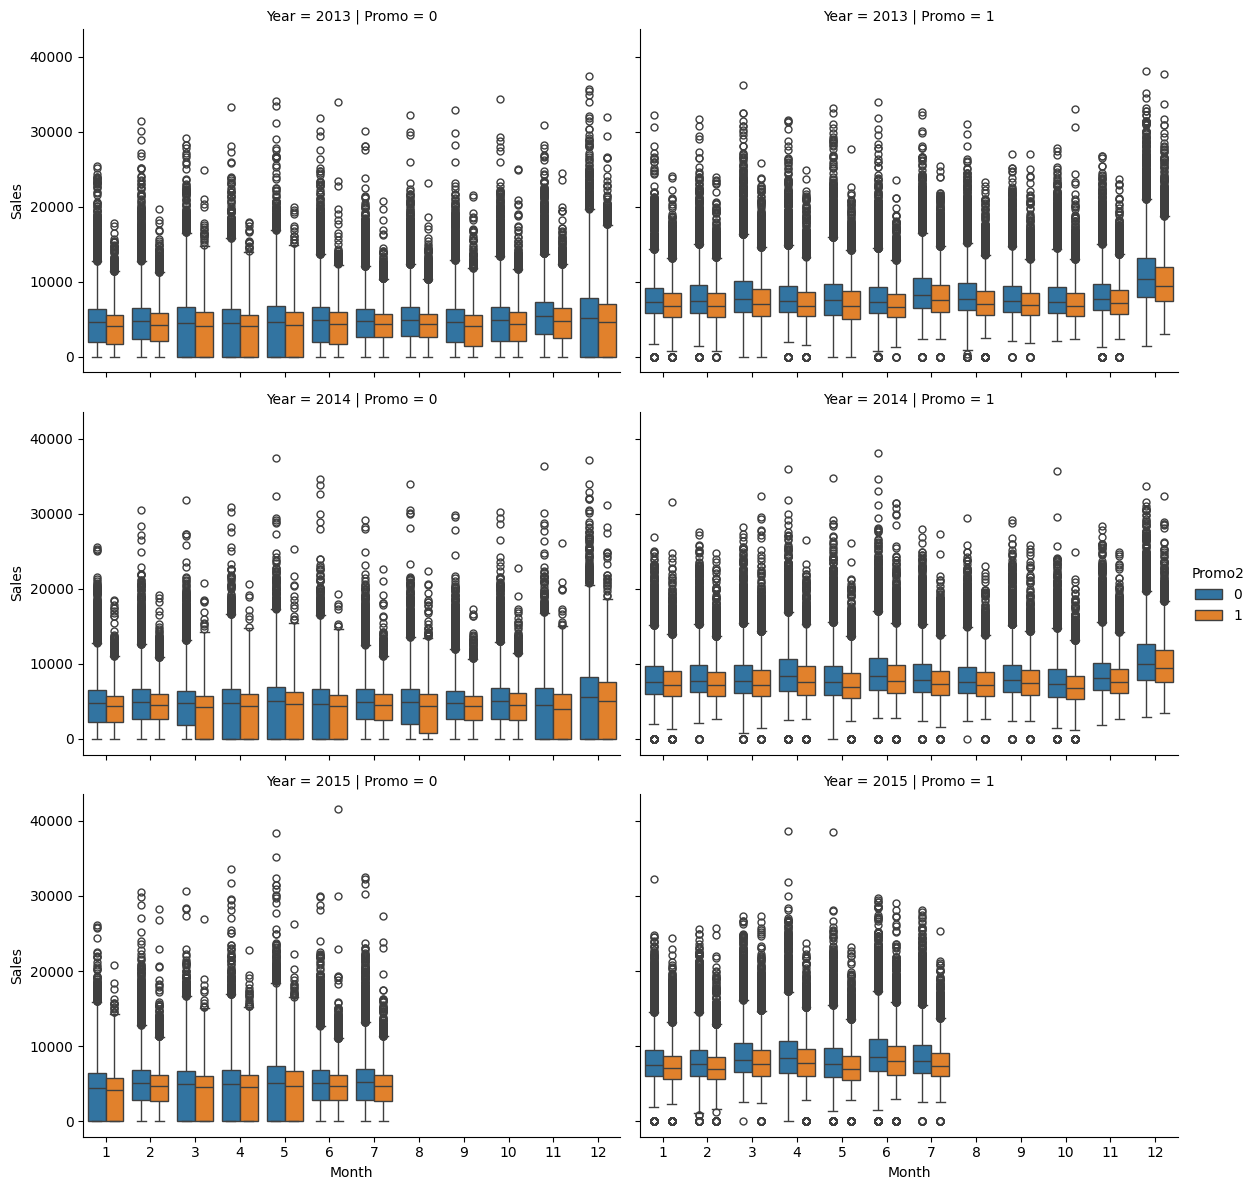

In [27]:
# boxplot of sales by month for promotion analysis
sns.catplot(
    data=merged_data,
    x="Month",
    y="Sales",
    col="Promo",
    hue="Promo2",
    row="Year",
    kind="box",
    height=4,
    aspect=1.5
)

### EDA AND VISUALIZATION

In [28]:
merged_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day'],
      dtype='object')

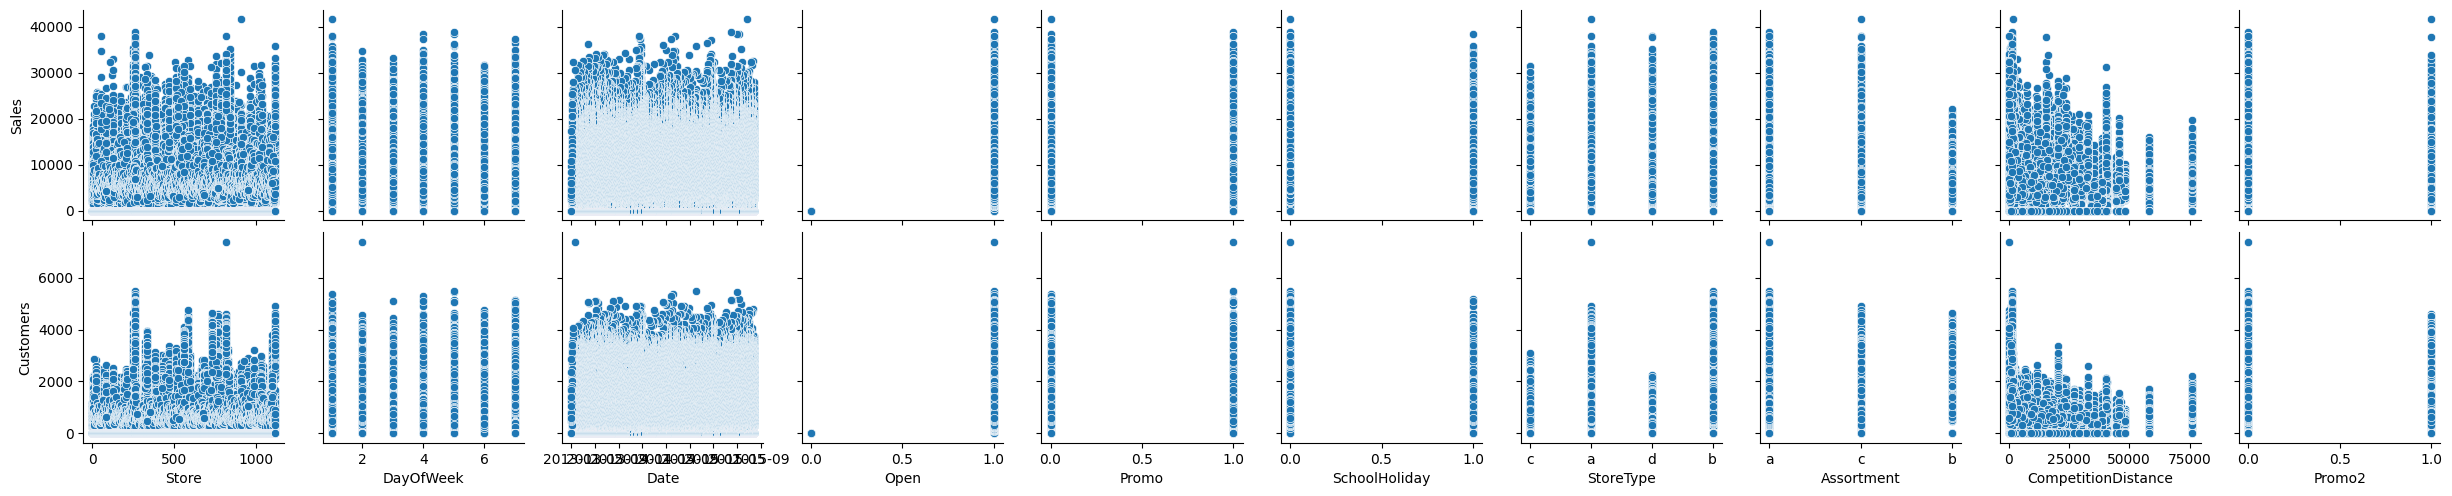

In [29]:
# Only use columns that exist in merged_data
sns.pairplot(
    merged_data,
    x_vars=['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2'],
    y_vars=['Sales', 'Customers']
)

<Axes: xlabel='Sales', ylabel='Count'>

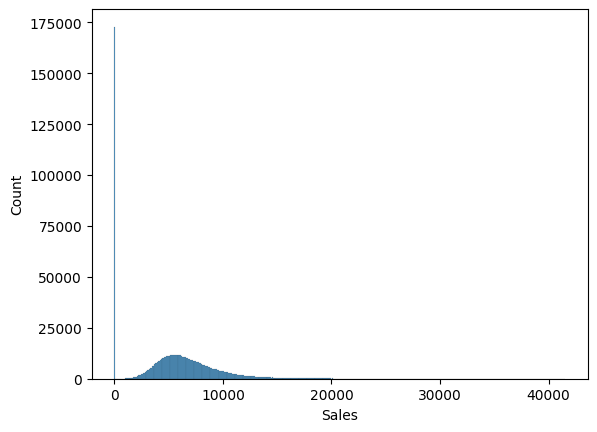

In [30]:
# what is the distribution of the target variable?
sns.histplot(data = merged_data, x = 'Sales')

In [31]:
# let's see the number of days the store was open and closed
merged_data.Open.value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

In [32]:
# count of days the store was closed
merged_data.Sales.value_counts()[0]


np.int64(172871)

In [33]:
# let's remove the dates where the store was closed
merged_data = merged_data[merged_data.Open == 1].copy()

<Axes: xlabel='Sales', ylabel='Count'>

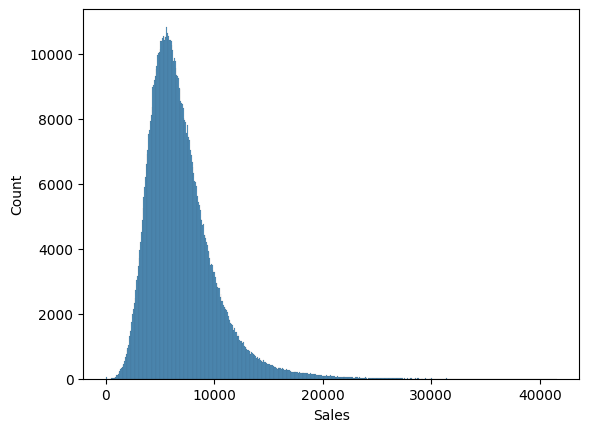

In [34]:
sns.histplot(data = merged_data, x = 'Sales')

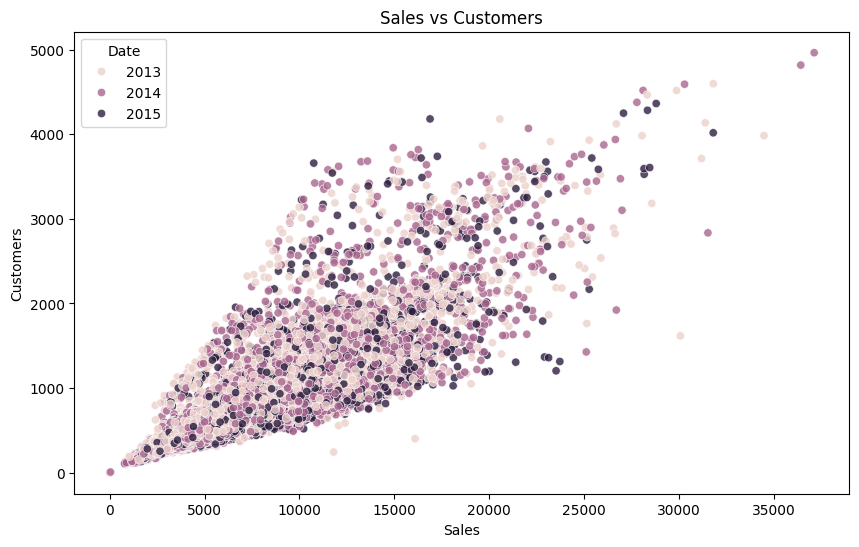

In [35]:
# sales vs customers chart

plt.figure(figsize=(10,6))
customer_sales = merged_data.sample(40000)
sns.scatterplot(x = customer_sales.Sales, y = customer_sales.Customers, hue=customer_sales.Date.dt.year, alpha = 0.8)
plt.title('Sales vs Customers')
plt.show()


#### Sales across different stores

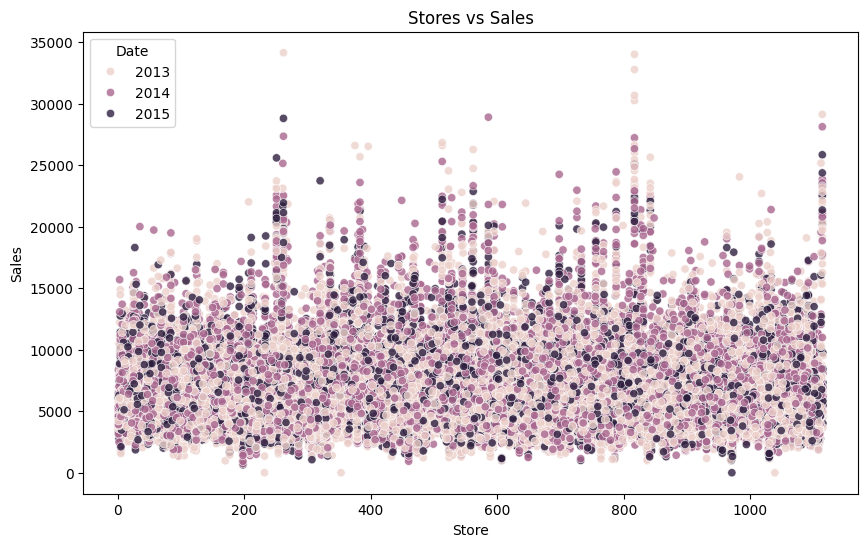

In [36]:
# stores vs sales chart
plt.figure(figsize=(10,6))
store_sales = merged_data.sample(40000)
sns.scatterplot(x = store_sales.Store, y = store_sales.Sales, hue = store_sales.Date.dt.year, alpha = 0.8)
plt.title('Stores vs Sales')
plt.show()

In [37]:
# try and predict how many customers will visit the store 

#### Sales across different days of the week

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

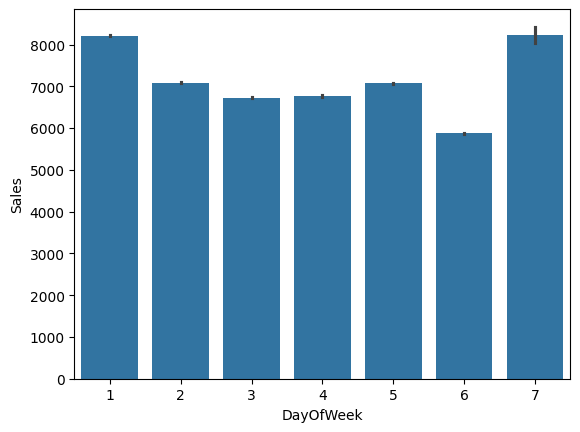

In [38]:
sns.barplot(data=merged_data, x='DayOfWeek', y='Sales')

#### Promo vs Sales

<Axes: xlabel='Promo', ylabel='Sales'>

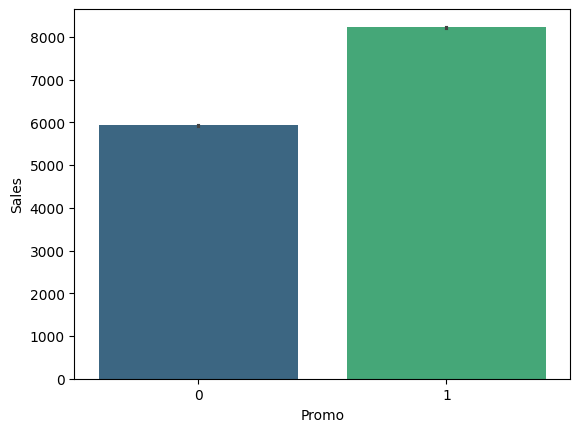

In [39]:
# barplot for Promo vs Sales
sns.barplot(data = merged_data, x = 'Promo', y= 'Sales', palette='viridis')



#### Sales across different years

<Axes: xlabel='Year', ylabel='Sales'>

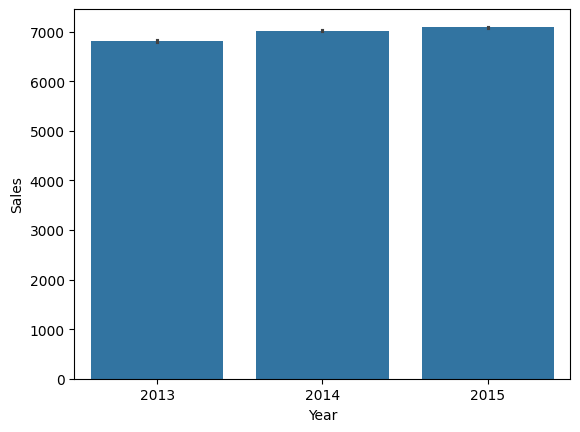

In [40]:
sns.barplot(data=merged_data, x='Year', y='Sales')


#### Sales across different months

<Axes: xlabel='Month', ylabel='Sales'>

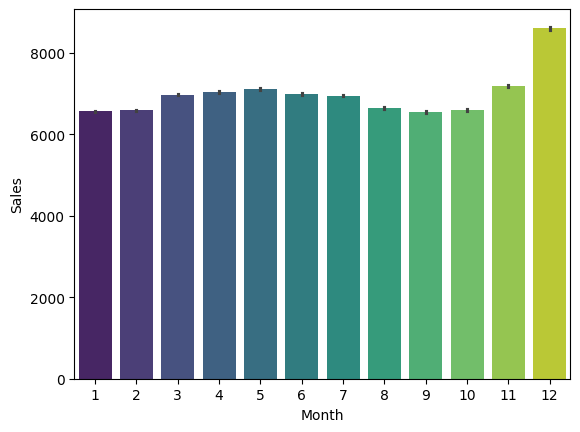

In [41]:
sns.barplot(data=merged_data, x='Month', y='Sales', palette='viridis')

### Impact of school holidays

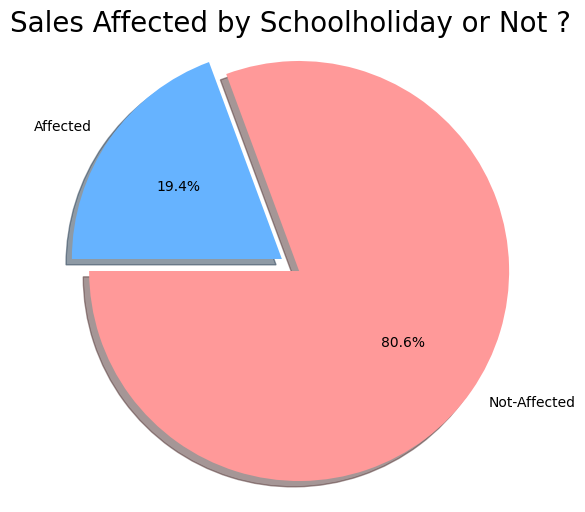

In [42]:
labels = 'Not-Affected' , 'Affected'
sizes = merged_data.SchoolHoliday.value_counts()
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?",fontsize=20)
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()


In [43]:
# In the pie chart above, we can see that the sales are affected by school holidays.
# Let's check the sales during school holidays and non-school holidays.
merged_data.SchoolHoliday.value_counts()

SchoolHoliday
0    680935
1    163457
Name: count, dtype: int64

### Impact of state holidays

In [44]:
# how about the sales affected by state holidays?
merged_data.StateHoliday.value_counts()

StateHoliday
0    731342
0    112140
a       694
b       145
c        71
Name: count, dtype: int64

In [45]:
# transform the state holiday column to numerical values
merged_data['StateHoliday'] = merged_data['StateHoliday'].map({'0': 0, 'a': 1, 'b': 1, 'c': 1})

In [46]:
merged_data.StateHoliday.value_counts().astype(int)  # convert to integer type

StateHoliday
0.0    731342
1.0       910
Name: count, dtype: int64

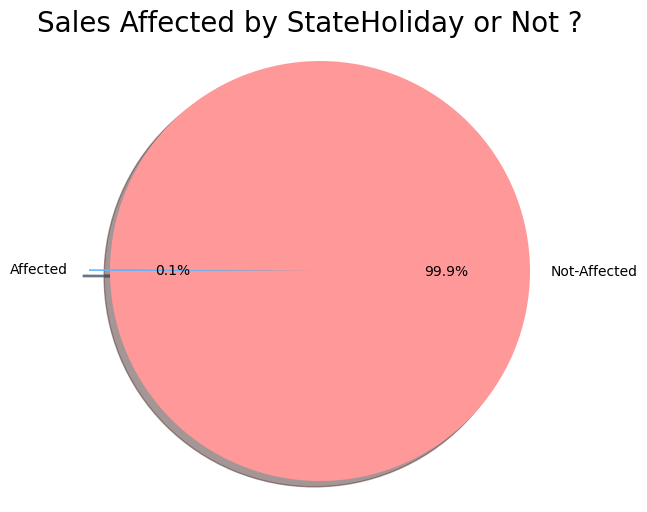

In [47]:
# chart for state holidays
labels = 'Not-Affected' , 'Affected'
sizes = merged_data.StateHoliday.value_counts()
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by StateHoliday or Not ?",fontsize=20)
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()


In [48]:
# sales is not affected by state holidays as much as school holidays.
# so we can drop the state holiday column
merged_data.drop('StateHoliday', axis=1, inplace=True)

#### Outliers in Sales

<Axes: xlabel='Sales'>

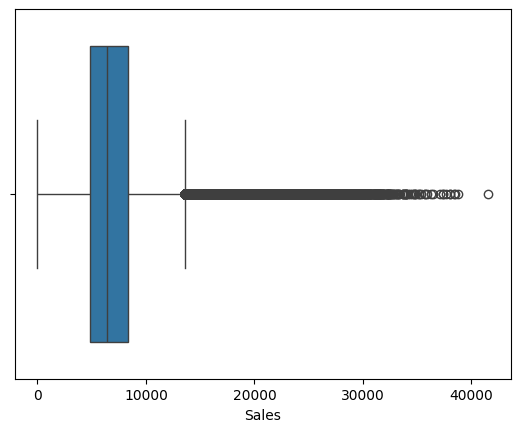

In [49]:
# check for outliers in sales
sns.boxplot(x=merged_data['Sales'])

In [50]:
# remove the outliers in sales
merged_data = merged_data[merged_data['Sales'] < 400000]

#### Bias in the data

In [51]:
# Bias in the data
# where stores are closed, they won't generate sales, so we will remove that part of the dataset
merged_data = merged_data[merged_data['Open'] == 1]

In [52]:
# Open isn't a variable anymore, so we'll drop it too
merged_data = merged_data.drop('Open', axis=1)

In [53]:
# Check if there's any opened store with zero sales
merged_data[merged_data['Sales'] == 0].shape

(54, 14)

In [54]:
# see the percentage of open stored with zero sales
zero_sales_percentage = (merged_data[merged_data['Sales'] == 0].shape[0] / merged_data.shape[0]) * 100
print(f"Percentage of opened stores with zero sales: {zero_sales_percentage:.2f}%")

Percentage of opened stores with zero sales: 0.01%


In [55]:
# remove this part of data to avoid bias
merged_data = merged_data[merged_data['Sales'] > 0]

In [56]:
# copy the cleaned data to a new DataFrame
cleaned_data = merged_data.copy()

In [101]:
cleaned_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Year', 'Month',
       'Day', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c'],
      dtype='object')

In [102]:
cleaned_data.shape

(844338, 17)

### Test Data

In [57]:
test = pd.read_csv('Data/test.csv')
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [58]:
merged_test = test.merge(stores, how = 'left', on='Store')
merged_test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,1
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,1
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,0


In [59]:
merged_test['Date'] = pd.to_datetime(merged_test['Date'])

In [60]:
merged_test['Year'] = merged_test.Date.dt.year
merged_test['Month'] = merged_test.Date.dt.month
merged_test['Day'] = merged_test.Date.dt.day


### Selecting features

In [61]:
cleaned_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2', 'Year', 'Month', 'Day'],
      dtype='object')

In [62]:
# encode categorical variables to numerical values, use one-hot encoding for categorical variables but leave the date column as it is
cleaned_data = pd.get_dummies(cleaned_data, columns=['StoreType', 'Assortment'], drop_first=True).astype(int)

In [63]:
cleaned_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,1438300800000000000,5263,555,1,1,1270,0,2015,7,31,0,1,0,0,0
1,2,5,1438300800000000000,6064,625,1,1,570,1,2015,7,31,0,0,0,0,0
2,3,5,1438300800000000000,8314,821,1,1,14130,1,2015,7,31,0,0,0,0,0
3,4,5,1438300800000000000,13995,1498,1,1,620,0,2015,7,31,0,1,0,0,1
4,5,5,1438300800000000000,4822,559,1,1,29910,0,2015,7,31,0,0,0,0,0


In [64]:
X = cleaned_data.drop(['Sales', 'Store', 'Date', 'Year'], axis=1)
y = cleaned_data['Sales']

In [65]:
X.shape, y.shape

((844338, 13), (844338,))

In [103]:
X.columns

Index(['DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Month', 'Day', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c'],
      dtype='object')

In [66]:
X.head()

,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,Month,Day,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,5,555,1,1,1270,0,7,31,0,1,0,0,0
1,5,625,1,1,570,1,7,31,0,0,0,0,0
2,5,821,1,1,14130,1,7,31,0,0,0,0,0
3,5,1498,1,1,620,0,7,31,0,1,0,0,1
4,5,559,1,1,29910,0,7,31,0,0,0,0,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
columns = X_train.columns

### Linear Regression

In [69]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

regressor.intercept_

np.float64(158.85385509303615)

In [70]:
regressor.coef_

array([-2.42167620e+02,  4.04924688e+04,  1.14886971e+03,  2.92967618e+01,
        1.92278822e+03,  3.06115320e+02,  2.71957473e+02,  5.33583019e+01,
       -3.22306283e+03, -1.44085218e+02,  1.13936277e+03, -4.11111180e+03,
        3.07777122e+02])

In [71]:
y_pred_train = regressor.predict(X_train)

y_pred = regressor.predict(X_test)

In [72]:
mean_squared_error(y_test, y_pred)

1713590.1363807283

In [73]:
np.sqrt(mean_squared_error(y_test, y_pred))

np.float64(1309.0416862654636)

In [74]:
train_score = regressor.score(X_train, y_train)
train_score
# OR

0.8236484332754708

In [75]:
train_score = r2_score(y_train, y_pred_train)
test_score = r2_score(y_test, y_pred)
print(f"Train R^2 Score: {train_score:.4f}")
print(f"Test R^2 Score: {test_score:.4f}")

Train R^2 Score: 0.8236
Test R^2 Score: 0.8224


In [76]:
# storing 100 observations for analysis
lr_pred = y_pred[:100]
lr_real = y_test[:100]
lr_data = pd.DataFrame({'Predicted': lr_pred, 'Actual': lr_real})

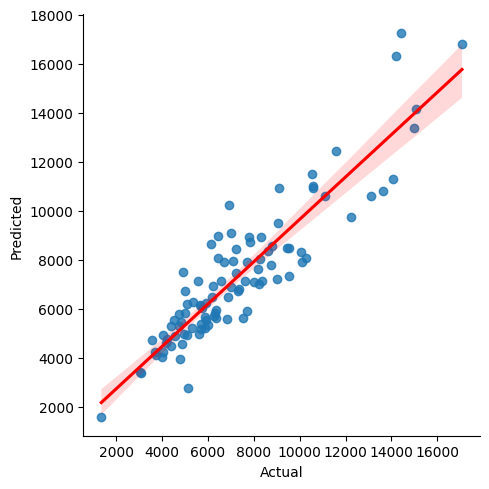

In [77]:
sns.lmplot(data=lr_data, x='Actual', y='Predicted', line_kws={'color': 'red'})

### LARS Lasso Reg

In [78]:
las = LassoLars(alpha=0.01, fit_intercept=False)
lasreg = las.fit(X_train, y_train)

In [79]:
def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100



In [80]:
train_score_2=lasreg.score(X_train, y_train)
test_score_2=lasreg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_2 , "," ,
      "Out of Sample Test Score" ,":" , test_score_2)

y_predicted = lasreg.predict(X_train)
y_test_predicted = lasreg.predict(X_test)

print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.8235188790062751 , Out of Sample Test Score : 0.8222233255776185
Training RMSE : 1303.6321446883549 Testing RMSE : 1309.7586768899646
Training MAPE : 14.480832450237308 Testing MAPE : 14.505362937924806


### Decision Tree Regression

In [81]:
tree = DecisionTreeRegressor()
treereg = tree.fit(X_train, y_train)

In [82]:
train_score_3=treereg.score(X_train, y_train)
test_score_3=treereg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_3 , "," ,
      "Test Score" ,":" , test_score_3)

y_predicted = treereg.predict(X_train)
y_test_predicted = treereg.predict(X_test)
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.9999945525391748 , Test Score : 0.9325243414263142
Training RMSE : 7.24274160963607 Testing RMSE : 806.9143916469188
Training MAPE : 0.0014611297609353525 Testing MAPE : 7.654216304249682


### KNN

### Random Forest

In [87]:
random_forest = RandomForestRegressor(n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_depth=None, n_jobs=-1)
random_forest_reg = random_forest.fit(X_train, y_train)


In [88]:
train_score_5=random_forest_reg.score(X_train, y_train)
test_score_5=random_forest_reg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_5 , "," ,
      "Test Score" ,":" , test_score_5)   

y_predicted_2 = random_forest_reg.predict(X_train)
y_test_predicted_2 = random_forest_reg.predict(X_test)

print("Training RMSE", ":", rmse(y_train, y_predicted_2),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted_2))
print("Training MAPE", ":", mape(y_train, y_predicted_2),
      "Testing MAPE", ":", mape(y_test, y_test_predicted_2))

Regresion Model Score : 0.9929187393501637 , Test Score : 0.962020750407963
Training RMSE : 261.13267884083695 Testing RMSE : 605.3786284738154
Training MAPE : 2.3762222950493657 Testing MAPE : 5.948299383163285


In [89]:
y_test_predicted_2

array([5832.3, 7905.7, 9054.8, ..., 7548.8, 4485.1, 6207.7],
      shape=(168868,))

In [90]:
#storing 100 observations for analysis
rf_prd = y_test_predicted_2[:100]
rf_real = y_test[:100]
dataset_rf = pd.DataFrame({'Real':rf_real,'PredictedRF':rf_prd})

In [91]:
#storing absolute diffrences between actual sales price and predicted
dataset_rf['diff']=(dataset_rf['Real']-dataset_rf['PredictedRF']).abs()

In [92]:
 # taking 4 sample
dataset_rf.sample(4)

,Real,PredictedRF,diff
929016,7199,6864.2,334.8
361857,3552,3805.6,253.6
953159,5740,5994.8,254.8
543966,8195,9614.4,1419.4


In [93]:
#Statistical description of our predictions and actual values 
dataset_rf.describe()

,Real,PredictedRF,diff
count,100.000000,100.000000,100.00000
mean,7272.120000,7309.915000,350.97100
std,2998.403196,3043.077338,369.43057
min,1347.000000,1492.600000,2.90000
25%,5091.500000,5132.775000,100.55000
50%,6499.000000,6669.750000,237.15000
75%,8641.750000,8728.725000,400.22500
max,17075.000000,17568.600000,1807.20000


In [95]:
score_df = pd.DataFrame(
	{
		'Train_Score': [train_score, train_score_2, train_score_3, train_score_5],
		'Test_Score': [test_score, test_score_2, test_score_3, test_score_5]
	},
	index=['Linear Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest Regression']
)

In [96]:
score_df

,Train_Score,Test_Score
Linear Regression,0.823648,0.822418
Lasso Regression,0.823519,0.822223
Decision Tree,0.999995,0.932524
Random Forest Regression,0.992919,0.962021


In [98]:
# The Random Forest Regression model has the highest test score, indicating it performs best on unseen data.
# The Decision Tree model has the lowest test score, indicating it performs worst on unseen data.


### Save the model in pickle

In [ ]:
pickle.dump(random_forest_reg, open('model.pkl', 'wb'))